On rajoute les données meteo

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import cm
from matplotlib.colors import ListedColormap

from sklearn.ensemble import RandomForestRegressor

In [42]:
stations_debit = pd.read_csv("../Data/Base/Stations_Debit.csv")
liste_stations_debit = list(stations_debit["Code station"])

mesures_train_X = pd.read_csv("../Data/Base/Mesures_Train_X.csv")
mesures_train_X["Date"] = pd.to_datetime(mesures_train_X["Date"], format = "%Y/%m/%d %H:%M:%S")
mesures_train_Y = pd.read_csv("../Data/Base/Mesures_Train_Y.csv")
mesures_train_Y["Date"] = pd.to_datetime(mesures_train_Y["Date"], format = "%Y/%m/%d %H:%M:%S")

train_split_X = pd.read_csv("../Data/Base/Index_CV_X.csv")
train_split_Y = pd.read_csv("../Data/Base/Index_CV_Y.csv")

mesures_test_X = pd.read_csv("../Data/Base/Mesures_Test_X.csv")
mesures_test_X["Date"] = pd.to_datetime(mesures_test_X["Date"], format = "%Y/%m/%d %H:%M:%S")
mesures_test_Y = pd.read_csv("../Data/Base/Mesures_Test_Y.csv")
mesures_test_Y["Date"] = pd.to_datetime(mesures_test_Y["Date"], format = "%Y/%m/%d %H:%M:%S")

In [43]:
stations_meteo = pd.read_csv("../Data/Base/Stations_Meteo.csv")
liste_stations_meteo = list(stations_meteo["ID"].apply(lambda x: str(x).rjust(5, "0")))
colonnes_meteo = ["Pression", "Vent_Nord", "Vent_Est", "Vitesse_vent", "Temperature", "Humidite", "Precipitations"]
tempo = []
for code in liste_stations_meteo:
    tempo += [tp + "_" + code for tp in colonnes_meteo]
colonnes_meteo_stations = tempo

In [44]:
#ajout des données débit d'eau du jour J-7

col_names=mesures_train_X.columns.tolist()
add_names = [i+"-7" for i in liste_stations_debit]
col_names = col_names + add_names
colonnes_meteo_stations = colonnes_meteo_stations + add_names

sft = mesures_train_X.shift(7).fillna(method="bfill")[liste_stations_debit]
mesures_train_X = pd.concat([mesures_train_X, sft], axis=1)
mesures_train_X.columns = col_names
mesures_train_X.fillna(method="bfill")

sft = mesures_train_Y.shift(7).fillna(method="bfill")[liste_stations_debit]
mesures_train_Y = pd.concat([mesures_train_Y, sft], axis=1)
mesures_train_Y.columns = col_names
mesures_train_Y.fillna(method="bfill")

sft = mesures_test_X.shift(7).fillna(method="bfill")[liste_stations_debit]
mesures_test_X = pd.concat([mesures_test_X, sft], axis=1)
mesures_test_X.columns = col_names
mesures_test_X.fillna(method="bfill")

sft = mesures_test_Y.shift(7).fillna(method="bfill")[liste_stations_debit]
mesures_test_Y = pd.concat([mesures_test_Y, sft], axis=1)
mesures_test_Y.columns = col_names
mesures_test_Y.fillna(method="bfill")

mesures_test_Y

,Date,O0200020,O2620010,O6140010,O9000010,K0030020,K0100020,K0260020,K0550010,K0690010,...,H0400010-7,H0400020-7,H0800011-7,H0800012-7,H0810010-7,H1700010-7,H3930020-7,H4340020-7,H5920014-7,H8100021-7
0,2020-01-15,32.558333,125.416667,303.500000,518.833333,0.962500,3.465000,9.922500,30.966667,33.968333,...,3.030000,3.516667,2.780000,13.500000,12.233333,24.766667,59.083333,59.450000,94.816667,255.616667
1,2020-01-16,34.158333,116.583333,322.416667,507.250000,0.943333,3.218333,9.325000,29.525000,34.380000,...,3.030000,3.516667,2.780000,13.500000,12.233333,24.766667,59.083333,59.450000,94.816667,255.616667
2,2020-01-17,36.283333,128.500000,319.000000,546.166667,0.958333,3.280000,9.489167,27.950000,35.800000,...,3.030000,3.516667,2.780000,13.500000,12.233333,24.766667,59.083333,59.450000,94.816667,255.616667
3,2020-01-18,38.525000,138.750000,345.583333,534.583333,0.927500,3.451667,11.091667,28.375000,70.450000,...,3.030000,3.516667,2.780000,13.500000,12.233333,24.766667,59.083333,59.450000,94.816667,255.616667
4,2020-01-19,34.666667,138.333333,335.083333,575.500000,0.888333,3.070000,9.660000,26.816667,68.816667,...,3.030000,3.516667,2.780000,13.500000,12.233333,24.766667,59.083333,59.450000,94.816667,255.616667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,2020-12-27,41.291667,188.250000,378.833333,627.666667,0.672500,3.170000,13.083333,30.383333,69.258333,...,81.716667,46.833333,55.000000,26.566667,80.066667,152.333333,534.000000,536.833333,825.833333,1115.000000
348,2020-12-28,51.316667,243.500000,425.666667,676.250000,0.683333,3.257500,13.516667,32.983333,85.591667,...,89.466667,53.100000,58.533333,28.833333,81.616667,156.166667,544.000000,561.500000,855.166667,1121.666667
349,2020-12-29,47.250000,552.666667,1474.750000,1975.833333,0.702500,3.126667,13.058333,35.491667,83.050000,...,98.400000,62.883333,70.433333,32.433333,82.100000,160.666667,546.166667,581.000000,887.333333,1180.000000
350,2020-12-30,47.225000,359.583333,1192.916667,2684.166667,0.760833,3.132500,12.375000,32.058333,43.616667,...,104.166667,59.100000,71.533333,33.000000,84.300000,163.833333,543.166667,564.833333,912.666667,1180.000000


In [45]:
%run Eval_fcts.py
%run Standardize_fcts.py

In [46]:
%run Regression_GAM_Gamma.py

# Val croisée

In [47]:
depth = 5
feature_grid = ["auto", "sqrt", "log2"]
sample_grid = [2, 4, 6, 8, 10]
n_knots = 10
n_esti=20

In [50]:
for curr_feature in feature_grid:
    
    for curr_sample in tqdm(sample_grid):
        cv_scores_RMSE_standard = pd.DataFrame({"Code station": liste_stations_debit})
        cv_scores_MAE_standard = pd.DataFrame({"Code station": liste_stations_debit})
        cv_scores_R2_standard = pd.DataFrame({"Code station": liste_stations_debit})
    
        cv_scores_RMSE = pd.DataFrame({"Code station": liste_stations_debit})
        cv_scores_MAE = pd.DataFrame({"Code station": liste_stations_debit})
        cv_scores_R2 = pd.DataFrame({"Code station": liste_stations_debit})
    
        for curr_split in range(9):
        
        # Entraintement
            curr_train_X = mesures_train_X[train_split_X["Train_" + str(curr_split)]]
            curr_train_Y = mesures_train_Y[train_split_Y["Train_" + str(curr_split)]]
        
            curr_train_X_mean = curr_train_X[liste_stations_debit + colonnes_meteo_stations].mean()
            for code in liste_stations_debit:
                curr_train_X_mean[code] = 0
            curr_train_X_std = curr_train_X[liste_stations_debit + colonnes_meteo_stations].std()
            curr_train_X_standard = fct_Standardize(curr_train_X, curr_train_X_mean,
                                                curr_train_X_std, liste_stations_debit + colonnes_meteo_stations)
            curr_train_X_standard["Date"] = curr_train_X["Date"]

            #GAM
            spline_fit = fct_Regression_SplineGamma_fit(curr_train_X_standard, liste_stations_debit, n_knots)
            curr_train_X_standard_residus = fct_Regression_SplineGamma_residus(spline_fit, 
                                                                               curr_train_X_standard, 
                                                                               liste_stations_debit)
            model_RF = RandomForestRegressor(n_estimators=n_esti, max_features=curr_feature,
                                            max_samples=curr_sample/10)
            

            model_RF.fit(X = curr_train_X_standard[colonnes_meteo_stations],
                  y = curr_train_X_standard_residus[liste_stations_debit])
        
            # Predictions Standard
            curr_test_X = mesures_train_X[train_split_X["Test_" + str(curr_split)]]
            curr_test_Y = mesures_train_Y[train_split_Y["Test_" + str(curr_split)]]
            liste_dates = curr_test_Y["Date"]
            curr_test_X_standard =fct_Standardize(curr_test_X, curr_train_X_mean,
                                              curr_train_X_std, liste_stations_debit + colonnes_meteo_stations)
            curr_test_X_standard["Date"] = curr_test_X["Date"].values
            
            predictions_test_Y_standard_residus = model_RF.predict(curr_test_X_standard[colonnes_meteo_stations])
            predictions_test_Y_standard_residus = pd.DataFrame(predictions_test_Y_standard_residus, columns=liste_stations_debit)
            predictions_test_Y_standard_residus["Date"] = curr_test_X_standard["Date"].values
            # Filtre sur les dates
            resultat = pd.DataFrame()
            for curr_date in liste_dates:
                resultat = pd.concat([resultat, predictions_test_Y_standard_residus[predictions_test_Y_standard_residus["Date"] == curr_date]])
            resultat = resultat.sort_values(by = "Date")
            predictions_test_Y_standard_residus = resultat.copy()
            # On rajoute la compo saisonnalité
            predictions_test_Y_standard_saisonnalite = fct_Regression_SplineGamma_predict(spline_fit, liste_dates, liste_stations_debit)
            predictions_test_Y_standard = predictions_test_Y_standard_residus[["Date"]].copy()
            for code in liste_stations_debit:
                predictions_test_Y_standard[code] = predictions_test_Y_standard_residus[code].values + predictions_test_Y_standard_saisonnalite[code].values

        
            # Score standard
            curr_test_Y_standard = fct_Standardize(curr_test_Y, 
                                                   curr_train_X_mean, curr_train_X_std, 
                                                   liste_stations_debit)
            curr_test_Y_standard["Date"] = curr_test_Y["Date"]
            curr_RMSE = fct_RMSE(curr_test_Y_standard, predictions_test_Y_standard, liste_stations_debit)
            cv_scores_RMSE_standard["Split_" + str(curr_split)] = curr_RMSE["RMSE"]
            curr_MAE = fct_MAE(curr_test_Y_standard, predictions_test_Y_standard, liste_stations_debit)
            cv_scores_MAE_standard["Split_" + str(curr_split)] = curr_MAE["MAE"]
            curr_R2 = fct_R2(curr_test_Y_standard, predictions_test_Y_standard, liste_stations_debit)
            cv_scores_R2_standard["Split_" + str(curr_split)] = curr_R2["R2"]
            # Score
            predictions_test_Y = fct_StandardizeInverse(predictions_test_Y_standard, 
                                                   curr_train_X_mean, curr_train_X_std, 
                                                   liste_stations_debit)
            predictions_test_Y["Date"] = predictions_test_Y_standard["Date"].values
            curr_RMSE = fct_RMSE(curr_test_Y, predictions_test_Y, liste_stations_debit)
            cv_scores_RMSE["Split_" + str(curr_split)] = curr_RMSE["RMSE"]
            curr_MAE = fct_MAE(curr_test_Y, predictions_test_Y, liste_stations_debit)
            cv_scores_MAE["Split_" + str(curr_split)] = curr_MAE["MAE"]
            curr_R2 = fct_R2(curr_test_Y, predictions_test_Y, liste_stations_debit)
            cv_scores_R2["Split_" + str(curr_split)] = curr_R2["R2"]
    
        cv_moyen_RMSE_standard = []
        cv_moyen_MAE_standard = []
        cv_moyen_R2_standard = []
    
        cv_moyen_RMSE = []
        cv_moyen_MAE = []
        cv_moyen_R2 = []

        for code in liste_stations_debit:
            score_RMSE = np.mean(cv_scores_RMSE_standard[cv_scores_RMSE_standard["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
            cv_moyen_RMSE_standard.append(score_RMSE)
            score_MAE = np.mean(cv_scores_MAE_standard[cv_scores_MAE_standard["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
            cv_moyen_MAE_standard.append(score_MAE)
            score_R2 = np.mean(cv_scores_R2_standard[cv_scores_R2_standard["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
            cv_moyen_R2_standard.append(score_R2)
            score_RMSE = np.mean(cv_scores_RMSE[cv_scores_RMSE["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
            cv_moyen_RMSE.append(score_RMSE)
            score_MAE = np.mean(cv_scores_MAE[cv_scores_MAE["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
            cv_moyen_MAE.append(score_MAE)
            score_R2 = np.mean(cv_scores_R2[cv_scores_R2["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
            cv_moyen_R2.append(score_R2)

        cv_scores_RMSE_standard["Moyenne"] = cv_moyen_RMSE_standard
        cv_scores_RMSE_standard.to_csv("../Data/RandomForest1/CV_RMSE_standard_" + str(curr_feature) + "_" + str(curr_sample) + ".csv",
                              index=False)
        cv_scores_MAE_standard["Moyenne"] = cv_moyen_MAE_standard
        cv_scores_MAE_standard.to_csv("../Data/RandomForest1/CV_MAE_standard_" + str(curr_feature) + "_" + str(curr_sample) + ".csv",
                              index=False)
        cv_scores_R2_standard["Moyenne"] = cv_moyen_R2_standard
        cv_scores_R2_standard.to_csv("../Data/RandomForest1/CV_R2_standard_" + str(curr_feature) + "_" + str(curr_sample) + ".csv",
                              index=False)
        cv_scores_RMSE["Moyenne"] = cv_moyen_RMSE
        cv_scores_RMSE.to_csv("../Data/RandomForest1/CV_RMSE_" + str(curr_feature) + "_" + str(curr_sample) + ".csv",
                              index=False)
        cv_scores_MAE["Moyenne"] = cv_moyen_MAE
        cv_scores_MAE.to_csv("../Data/RandomForest1/CV_MAE_" + str(curr_feature) + "_" + str(curr_sample) + ".csv",
                              index=False)
        cv_scores_R2["Moyenne"] = cv_moyen_R2
        cv_scores_R2.to_csv("../Data/RandomForest1/CV_R2_" + str(curr_feature) + "_" + str(curr_sample) + ".csv",
                              index=False)
print("OK")

100%|█████████████████████████████████████████████| 5/5 [02:14<00:00, 26.98s/it]

OK


## Selection

In [51]:
n_cours_eau = 3
cours_eau = list(np.unique(stations_debit["Cours eau"]))
cours_eau_cmap = cm.get_cmap(ListedColormap(["red", "green", "blue"]))
cours_eau_couleur = pd.DataFrame({"Cours eau": cours_eau, "Index": range(n_cours_eau), "Couleur": ["red", "green", "blue"]})
cours_eau_couleur

,Cours eau,Index,Couleur
0,Garonne,0,red
1,Loire,1,green
2,Seine,2,blue


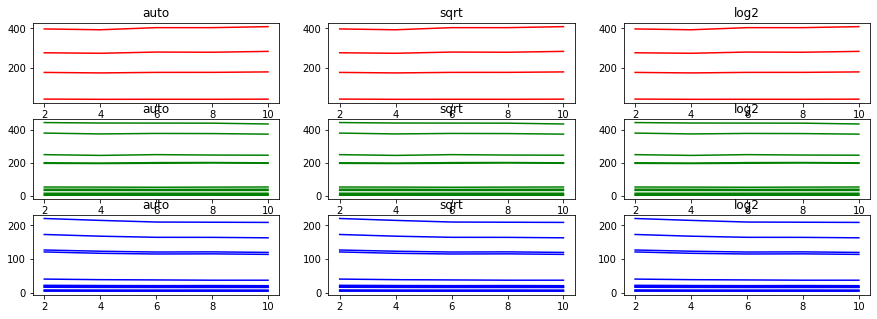

In [52]:
cv_moyen = pd.DataFrame()

for curr_feature in feature_grid:
    for curr_sample in sample_grid:
        curr_moyen = {}
        cv_scores = pd.read_csv("../Data/RandomForest1/CV_RMSE_" + str(curr_feature) + "_" + str(curr_sample) + ".csv")
        for code in liste_stations_debit:
            curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
        curr_moyen = pd.DataFrame(curr_moyen)
        curr_moyen["Max_features"] = curr_feature
        curr_moyen["Max_samples"] = curr_sample
        cv_moyen = pd.concat([cv_moyen, curr_moyen])

fig, axs = plt.subplots(n_cours_eau, len(feature_grid), figsize = (15,5))
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == list(cours_eau_couleur[cours_eau_couleur["Index"] == i]["Cours eau"])[0]]["Code station"])
    for code in stations:
        for j in range(len(feature_grid)):
            axs[i,j].plot(cv_moyen[cv_moyen["Max_features"] == feature_grid[i]]["Max_samples"], 
                          cv_moyen[cv_moyen["Max_features"] == feature_grid[i]][code],
                          color = cours_eau_cmap(i))
            axs[i,j].set_title(feature_grid[j])
plt.show()

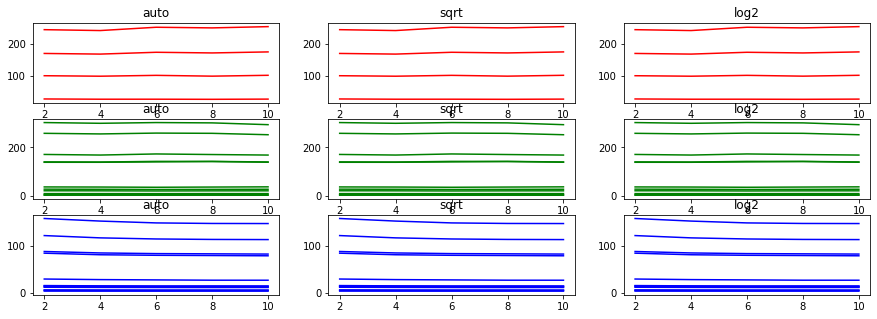

In [53]:
cv_moyen = pd.DataFrame()

for curr_feature in feature_grid:
    for curr_sample in sample_grid:
        curr_moyen = {}
        cv_scores = pd.read_csv("../Data/RandomForest1/CV_MAE_" + str(curr_feature) + "_" + str(curr_sample) + ".csv")
        for code in liste_stations_debit:
            curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
        curr_moyen = pd.DataFrame(curr_moyen)
        curr_moyen["Max_features"] = curr_feature
        curr_moyen["Max_samples"] = curr_sample
        cv_moyen = pd.concat([cv_moyen, curr_moyen])

fig, axs = plt.subplots(n_cours_eau, len(feature_grid), figsize = (15,5))
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == list(cours_eau_couleur[cours_eau_couleur["Index"] == i]["Cours eau"])[0]]["Code station"])
    for code in stations:
        for j in range(len(feature_grid)):
            axs[i,j].plot(cv_moyen[cv_moyen["Max_features"] == feature_grid[i]]["Max_samples"], 
                          cv_moyen[cv_moyen["Max_features"] == feature_grid[i]][code],
                          color = cours_eau_cmap(i))
            axs[i,j].set_title(feature_grid[j])
plt.show()

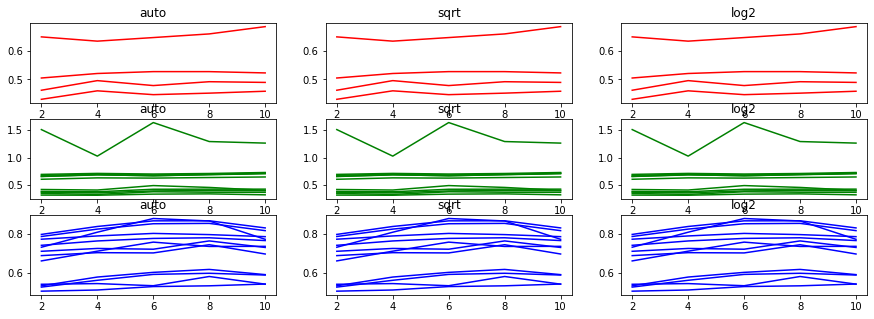

In [54]:
cv_moyen = pd.DataFrame()

for curr_feature in feature_grid:
    for curr_sample in sample_grid:
        curr_moyen = {}
        cv_scores = pd.read_csv("../Data/RandomForest1/CV_R2_" + str(curr_feature) + "_" + str(curr_sample) + ".csv")
        for code in liste_stations_debit:
            curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
        curr_moyen = pd.DataFrame(curr_moyen)
        curr_moyen["Max_features"] = curr_feature
        curr_moyen["Max_samples"] = curr_sample
        cv_moyen = pd.concat([cv_moyen, curr_moyen])

fig, axs = plt.subplots(n_cours_eau, len(feature_grid), figsize = (15,5))
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == list(cours_eau_couleur[cours_eau_couleur["Index"] == i]["Cours eau"])[0]]["Code station"])
    for code in stations:
        for j in range(len(feature_grid)):
            axs[i,j].plot(cv_moyen[cv_moyen["Max_features"] == feature_grid[i]]["Max_samples"], 
                          cv_moyen[cv_moyen["Max_features"] == feature_grid[i]][code],
                          color = cours_eau_cmap(i))
            axs[i,j].set_title(feature_grid[j])
plt.show()

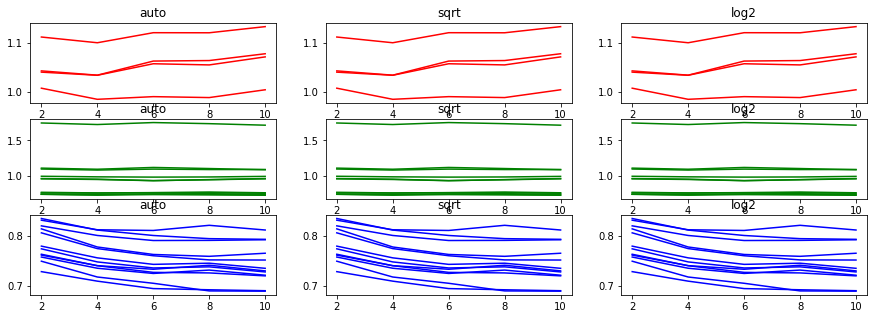

In [55]:
cv_moyen = pd.DataFrame()

for curr_feature in feature_grid:
    for curr_sample in sample_grid:
        curr_moyen = {}
        cv_scores = pd.read_csv("../Data/RandomForest1/CV_RMSE_standard_" + str(curr_feature) + "_" + str(curr_sample) + ".csv")
        for code in liste_stations_debit:
            curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
        curr_moyen = pd.DataFrame(curr_moyen)
        curr_moyen["Max_features"] = curr_feature
        curr_moyen["Max_samples"] = curr_sample
        cv_moyen = pd.concat([cv_moyen, curr_moyen])

fig, axs = plt.subplots(n_cours_eau, len(feature_grid), figsize = (15,5))
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == list(cours_eau_couleur[cours_eau_couleur["Index"] == i]["Cours eau"])[0]]["Code station"])
    for code in stations:
        for j in range(len(feature_grid)):
            axs[i,j].plot(cv_moyen[cv_moyen["Max_features"] == feature_grid[i]]["Max_samples"], 
                          cv_moyen[cv_moyen["Max_features"] == feature_grid[i]][code],
                          color = cours_eau_cmap(i))
            axs[i,j].set_title(feature_grid[j])
plt.show()

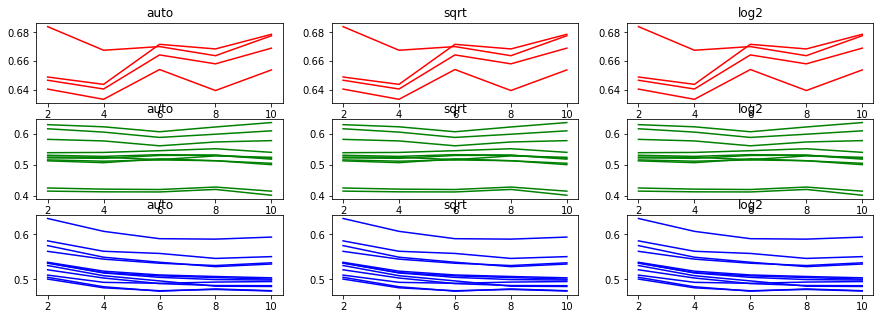

In [56]:
cv_moyen = pd.DataFrame()

for curr_feature in feature_grid:
    for curr_sample in sample_grid:
        curr_moyen = {}
        cv_scores = pd.read_csv("../Data/RandomForest1/CV_MAE_standard_" + str(curr_feature) + "_" + str(curr_sample) + ".csv")
        for code in liste_stations_debit:
            curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
        curr_moyen = pd.DataFrame(curr_moyen)
        curr_moyen["Max_features"] = curr_feature
        curr_moyen["Max_samples"] = curr_sample
        cv_moyen = pd.concat([cv_moyen, curr_moyen])

fig, axs = plt.subplots(n_cours_eau, len(feature_grid), figsize = (15,5))
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == list(cours_eau_couleur[cours_eau_couleur["Index"] == i]["Cours eau"])[0]]["Code station"])
    for code in stations:
        for j in range(len(feature_grid)):
            axs[i,j].plot(cv_moyen[cv_moyen["Max_features"] == feature_grid[i]]["Max_samples"], 
                          cv_moyen[cv_moyen["Max_features"] == feature_grid[i]][code],
                          color = cours_eau_cmap(i))
            axs[i,j].set_title(feature_grid[j])
plt.show()

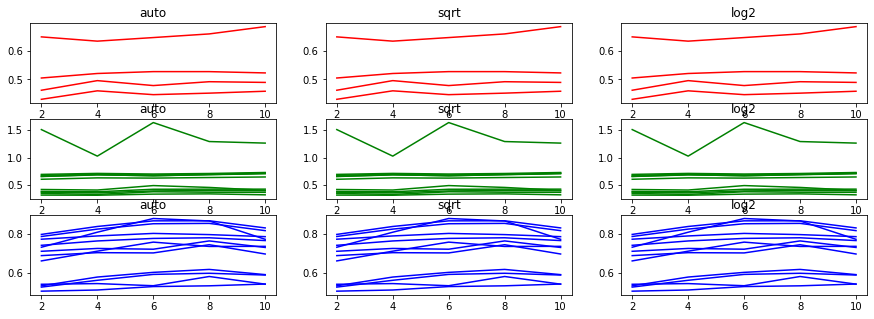

In [57]:
cv_moyen = pd.DataFrame()

for curr_feature in feature_grid:
    for curr_sample in sample_grid:
        curr_moyen = {}
        cv_scores = pd.read_csv("../Data/RandomForest1/CV_R2_" + str(curr_feature) + "_" + str(curr_sample) + ".csv")
        for code in liste_stations_debit:
            curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
        curr_moyen = pd.DataFrame(curr_moyen)
        curr_moyen["Max_features"] = curr_feature
        curr_moyen["Max_samples"] = curr_sample
        cv_moyen = pd.concat([cv_moyen, curr_moyen])

fig, axs = plt.subplots(n_cours_eau, len(feature_grid), figsize = (15,5))
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == list(cours_eau_couleur[cours_eau_couleur["Index"] == i]["Cours eau"])[0]]["Code station"])
    for code in stations:
        for j in range(len(feature_grid)):
            axs[i,j].plot(cv_moyen[cv_moyen["Max_features"] == feature_grid[i]]["Max_samples"], 
                          cv_moyen[cv_moyen["Max_features"] == feature_grid[i]][code],
                          color = cours_eau_cmap(i))
            axs[i,j].set_title(feature_grid[j])
plt.show()

## Moyen

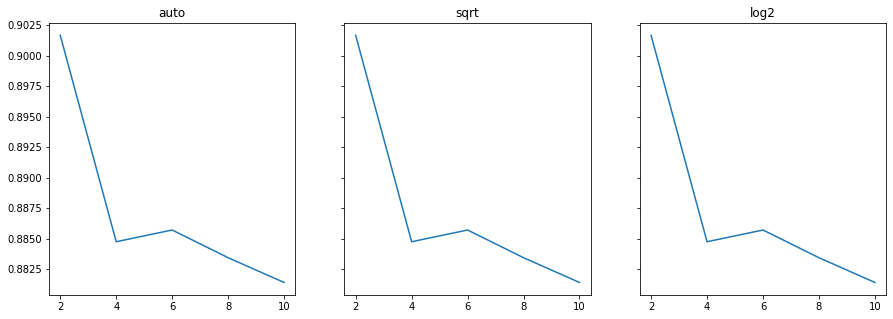

In [58]:
cv_moyen = pd.DataFrame()

for curr_feature in feature_grid:
    for curr_sample in sample_grid:
        curr_moyen = {}
        cv_scores = pd.read_csv("../Data/RandomForest1/CV_RMSE_standard_" + str(curr_feature) + "_" + str(curr_sample) + ".csv")
        for code in liste_stations_debit:
            curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
        curr_moyen = pd.DataFrame(curr_moyen)
        curr_moyen["Max_features"] = curr_feature
        curr_moyen["Max_samples"] = curr_sample
        cv_moyen = pd.concat([cv_moyen, curr_moyen])

fig, axs = plt.subplots(1, len(feature_grid), figsize = (15,5), sharey=True)
for j in range(len(feature_grid)):
    axs[j].plot(cv_moyen[cv_moyen["Max_features"] == feature_grid[i]]["Max_samples"], 
                  cv_moyen[cv_moyen["Max_features"] == feature_grid[i]][liste_stations_debit].mean(axis = 1).values,)
    axs[j].set_title(feature_grid[j])
plt.show()


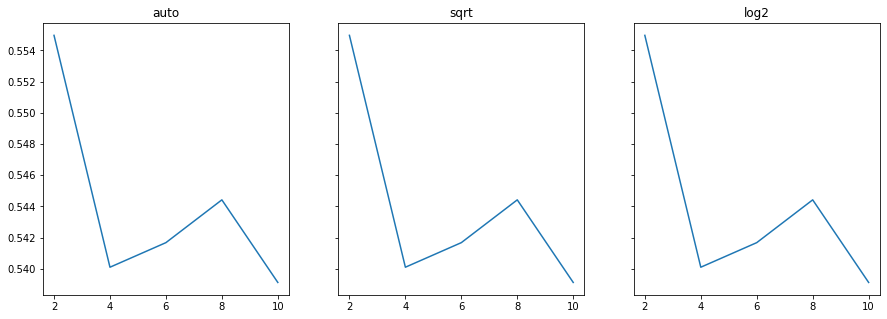

In [59]:
cv_moyen = pd.DataFrame()

for curr_feature in feature_grid:
    for curr_sample in sample_grid:
        curr_moyen = {}
        cv_scores = pd.read_csv("../Data/RandomForest1/CV_MAE_standard_" + str(curr_feature) + "_" + str(curr_sample) + ".csv")
        for code in liste_stations_debit:
            curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
        curr_moyen = pd.DataFrame(curr_moyen)
        curr_moyen["Max_features"] = curr_feature
        curr_moyen["Max_samples"] = curr_sample
        cv_moyen = pd.concat([cv_moyen, curr_moyen])

fig, axs = plt.subplots(1, len(feature_grid), figsize = (15,5), sharey=True)
for j in range(len(feature_grid)):
    axs[j].plot(cv_moyen[cv_moyen["Max_features"] == feature_grid[i]]["Max_samples"], 
                  cv_moyen[cv_moyen["Max_features"] == feature_grid[i]][liste_stations_debit].mean(axis = 1).values,)
    axs[j].set_title(feature_grid[j])
plt.show()

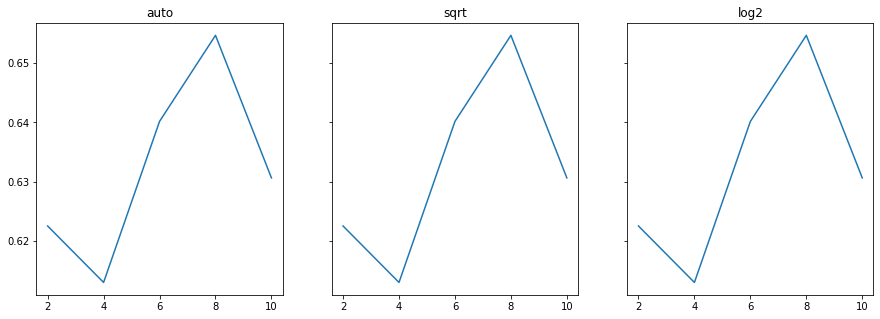

In [60]:
cv_moyen = pd.DataFrame()

for curr_feature in feature_grid:
    for curr_sample in sample_grid:
        curr_moyen = {}
        cv_scores = pd.read_csv("../Data/RandomForest1/CV_R2_standard_" + str(curr_feature) + "_" + str(curr_sample) + ".csv")
        for code in liste_stations_debit:
            curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
        curr_moyen = pd.DataFrame(curr_moyen)
        curr_moyen["Max_features"] = curr_feature
        curr_moyen["Max_samples"] = curr_sample
        cv_moyen = pd.concat([cv_moyen, curr_moyen])

fig, axs = plt.subplots(1, len(feature_grid), figsize = (15,5), sharey=True)
for j in range(len(feature_grid)):
    axs[j].plot(cv_moyen[cv_moyen["Max_features"] == feature_grid[i]]["Max_samples"], 
                  cv_moyen[cv_moyen["Max_features"] == feature_grid[i]][liste_stations_debit].mean(axis = 1).values,)
    axs[j].set_title(feature_grid[j])
plt.show()

# Test

In [61]:
sample = 0.8

In [62]:
# Donnees
mesures_train_X_mean = mesures_train_X[liste_stations_debit + colonnes_meteo_stations].mean()
mesures_train_X_std = mesures_train_X[liste_stations_debit + colonnes_meteo_stations].std()
mesures_train_X_standard = fct_Standardize(mesures_train_X, 
                                           mesures_train_X_mean, mesures_train_X_std, 
                                           liste_stations_debit + colonnes_meteo_stations)
mesures_train_X_standard["Date"] = mesures_train_X["Date"]

mesures_test_X_standard =fct_Standardize(mesures_test_X, mesures_train_X_mean, mesures_train_X_std, 
                                         liste_stations_debit + colonnes_meteo_stations)
mesures_test_X_standard["Date"] = mesures_test_X["Date"].values
mesures_test_Y_standard = fct_Standardize(mesures_test_Y, mesures_train_X_mean, mesures_train_X_std, 
                                          liste_stations_debit)
mesures_test_Y_standard["Date"] = mesures_test_Y["Date"]
liste_dates = mesures_test_Y["Date"]

In [63]:
# Entrainement
model_RF = RandomForestRegressor(max_features=curr_feature,
                                max_samples=sample)
model_RF.fit(X = mesures_train_X_standard[colonnes_meteo_stations],
      y = mesures_train_X_standard[liste_stations_debit])

RandomForestRegressor(max_features='log2', max_samples=0.8)

In [64]:
# Predictions
predictions_test_Y_standard = model_RF.predict(mesures_test_X_standard[colonnes_meteo_stations])
predictions_test_Y_standard = pd.DataFrame(predictions_test_Y_standard, columns=liste_stations_debit)
predictions_test_Y_standard["Date"] = mesures_test_X_standard["Date"].values
    # Filtre sur les dates
resultat = pd.DataFrame()
for curr_date in liste_dates:
    resultat = pd.concat([resultat, predictions_test_Y_standard[predictions_test_Y_standard["Date"] == curr_date]])
resultat = resultat.sort_values(by = "Date")
predictions_test_Y_standard = resultat.copy()

In [65]:
predictions_test_Y = fct_StandardizeInverse(predictions_test_Y_standard, mesures_train_X_mean,
                                              mesures_train_X_std, liste_stations_debit)
predictions_test_Y["Date"] = predictions_test_Y_standard["Date"].values

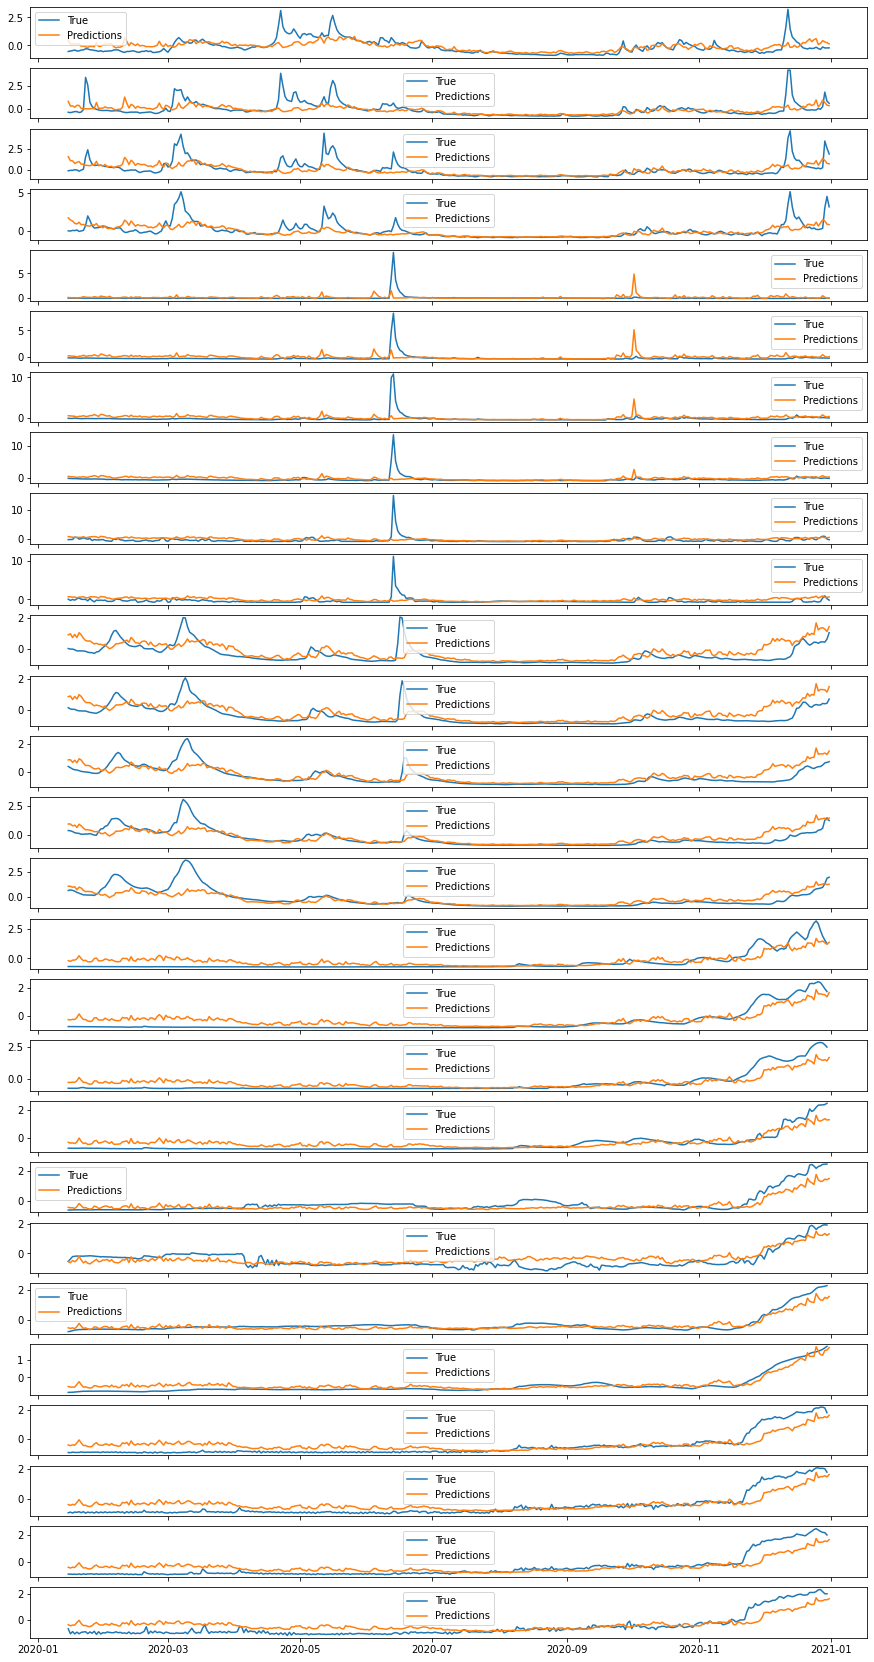

In [66]:
n_stations = len(liste_stations_debit)
fig, axs = plt.subplots(n_stations, 1, figsize = (15,30), sharex=True)
for i in range(n_stations):
    code = liste_stations_debit[i]
    axs[i].plot(mesures_test_Y_standard["Date"], mesures_test_Y_standard[code], label = "True")
    axs[i].plot(predictions_test_Y_standard["Date"], predictions_test_Y_standard[code], label = "Predictions")
    axs[i].legend()

In [67]:
scores_rmse_standard = fct_RMSE(mesures_test_Y_standard, predictions_test_Y_standard, liste_stations_debit)
scores_mae_standard = fct_MAE(mesures_test_Y_standard, predictions_test_Y_standard, liste_stations_debit)
scores_r2_standard = fct_R2(mesures_test_Y_standard, predictions_test_Y_standard, liste_stations_debit)

test_scores_standard = pd.DataFrame({"Code station": liste_stations_debit,
                            "RMSE": scores_rmse_standard["RMSE"],
                            "MAE": scores_mae_standard["MAE"],
                            "R2": scores_r2_standard["R2"]})
test_scores_standard.to_csv("../Data/RandomForest1/Test_scores_standard.csv",
                   index = False)
test_scores_standard

,Code station,RMSE,MAE,R2
0,O0200020,0.515793,0.350755,0.301380
1,O2620010,0.688808,0.383636,0.216448
2,O6140010,0.770418,0.437645,0.343962
3,O9000010,0.831026,0.450557,0.345365
4,K0030020,0.673626,0.219270,0.291378
5,K0100020,0.716814,0.346636,0.382236
6,K0260020,0.974432,0.431010,0.220256
7,K0550010,1.018602,0.490452,0.199571
8,K0690010,1.084117,0.557752,0.177874
9,K0910050,0.903015,0.543603,0.205873


In [68]:
test_scores_standard[["RMSE", "MAE", "R2"]].mean()

RMSE    0.716948
MAE     0.391295
R2      0.394979
dtype: float64

In [69]:
scores_rmse = fct_RMSE(mesures_test_Y, predictions_test_Y, liste_stations_debit)
scores_mae = fct_MAE(mesures_test_Y, predictions_test_Y, liste_stations_debit)
scores_r2 = fct_R2(mesures_test_Y, predictions_test_Y, liste_stations_debit)

test_scores = pd.DataFrame({"Code station": liste_stations_debit,
                            "RMSE": scores_rmse["RMSE"],
                            "MAE": scores_mae["MAE"],
                            "R2": scores_r2["R2"]})
test_scores.to_csv("../Data/RandomForest1/Test_scores.csv",
                   index = False)
test_scores

,Code station,RMSE,MAE,R2
0,O0200020,23.943950,16.282645,0.301380
1,O2620010,136.531520,76.042112,0.216448
2,O6140010,253.499309,144.003138,0.343962
3,O9000010,404.057213,219.067392,0.345365
4,K0030020,4.131061,1.344692,0.291378
5,K0100020,6.749403,3.263868,0.382236
6,K0260020,18.050852,7.984245,0.220256
7,K0550010,37.110166,17.868368,0.199571
8,K0690010,48.499684,24.951895,0.177874
9,K0910050,52.142355,31.389009,0.205873
